<a href="https://colab.research.google.com/github/cacbondioxit/2023-K-NET-ML-DL-Study/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%B2%98%EC%9D%8C%EB%B6%80%ED%84%B0_%EB%81%9D%EA%B9%8C%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**4회차 – 머신러닝 프로젝트 처음부터 끝까지**

K-NET ML/DL 스터디원 여러분 안녕하세요?

이 코드는 핸즈온 머신러닝 3판 역자이신 박해선 님 깃허브(https://github.com/rickiepark/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb )에 있던 코드에 주석을 달고 약간만 수정한 것입니다. 

이번 프로젝트의 목표은 캘리포니아 지역 주택의 여러 특성을 사용해 **각 지역의 중위 주택 가격(median_house_value)을 예측하는 것입니다.**

이 데이터는 캘리포니아의 블록 그룹마다 인구, 중위 소득, 중위 주택 가격 등을 담고 있습니다.

퀴즈: 이 문제는 지도학습, 비지도학습, 강화학습 중 어느 문제인가요?

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 가져오기

## 데이터 다운로드하기

In [ ]:
import os
import tarfile
import urllib.request
from pathlib import Path

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## 데이터 구조 훑어 보기

In [ ]:
# 데이터프레임 맨 위 5줄 보기
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# 데이터프레임에 대한 정보
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# ocean_proximity 변수만 자료형이 object입니다. 범주형 변수인 것 같으니 더 살펴봅시다.
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
# 데이터프레임의 통계량을 살펴봅시다.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


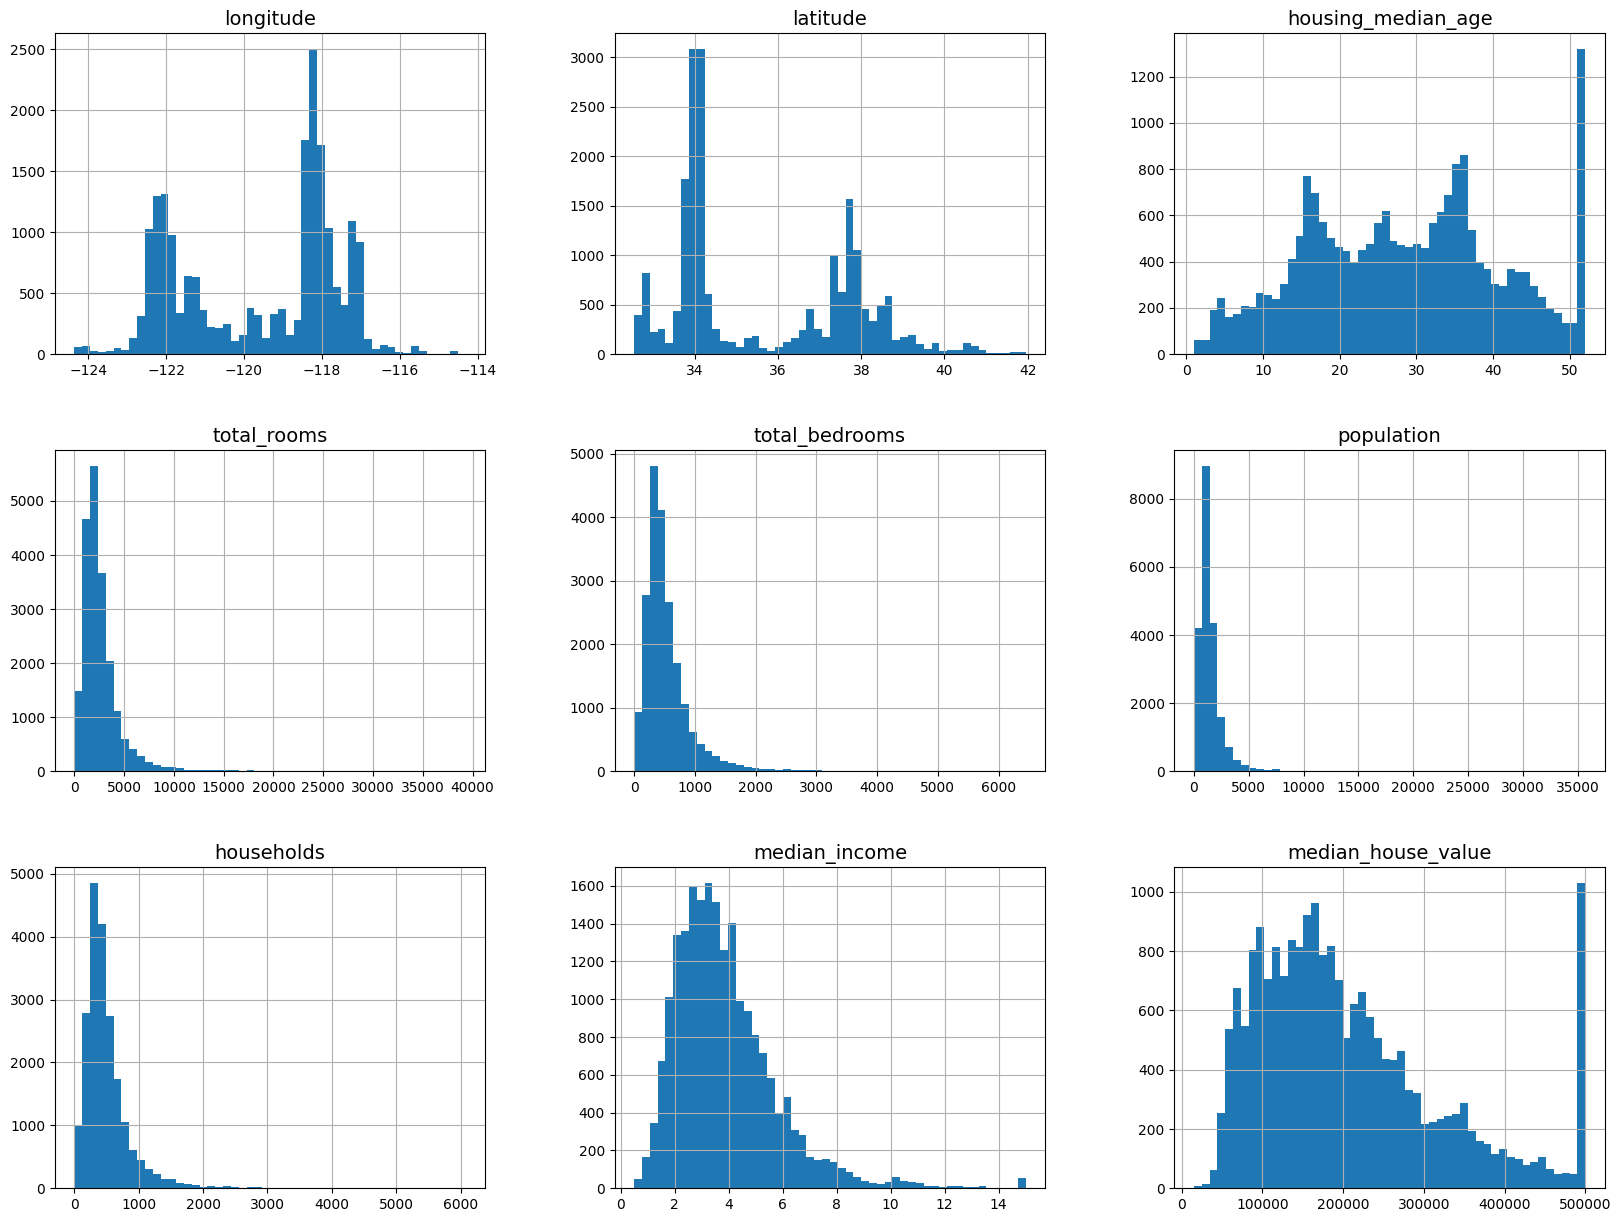

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(20,15))
plt.show()

위의 히스토그램에서 몇 가지 사항을 확인할 수 있는데요,

첫 번째는 median_income(중위 소득) 변수의 단위가 US 달러가 아닌 것 같습니다. 
책에 따르면, 데이터를 취합한 팀에서 스케일을 조정하여 상한이 15, 하한이 0.5가 되도록 만들었다고 합니다.
사실 이는 큰 문제는 아니지만, 데이터가 어떻게 계산된 것인지 반드시 이해해야 합니다.

두 번째는 housing_median_age(주택의 중위 연식)과 median_house_value(중위 주택 가격) 역시 최댓값과 최솟값이 한정되어 있습니다.
특히 중위 주택 가격의 경우는 타깃 속성으로 사용되기 때문에 모델의 성능에 심각한 문제를 줄지도 모릅니다.
왜냐하면 가격이 저 한계값인 500000 달러를 넘어가지 않도록 머신러닝 모델이 학습될지도 모르기 때문입니다. 
우리가 쓸 수 있는 방법은 두 가지입니다.
1. 50만 달러 밖의 구역에 대한 정확한 값을 구합니다.
2. 훈련 세트와 테스트 세트에서 저런 값을 제거합니다. 

세 번째는 특성들의 스케일이 서로 많이 다릅니다. 특성 스케일링에 대해서는 뒷부분에서 살펴봅니다.

네 번째는 많은 히스토그램이 비대칭입니다. 이런 형태는 일부 머신러닝 모델에서 학습에 방해가 됩니다. 나중에 이런 특성들을 좀 더 정규분포에 가깝게 변형시키겠습니다.


## 테스트 세트 만들기

데이터를 더 깊게 들여다보기 전에 테스트 세트를 따로 떼어놓읍시다. 이 테스트 세트는 성능 평가를 위해 쓸 것이기 때문에 들여다보면 안됩니다.

In [ ]:
# 사이킷런에서 제공하는 train_test_split을 사용하여 train set과 test set으로 나눌 수 있습니다.
# 하지만 이는 순수히 무작위로만 나누는 것이기 때문에, 원래 데이터의 분포와 훈련 데이터의 분포가 같지 않을 수도 있습니다.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN


In [ ]:
# 설문 조사 기관에서 남녀 1000명을 뽑을 때 무작위로 전화번호부에서 고르지 않습니다.
# 만약 우리나라 전체 인구에서 남자가 48.7%이고 여자가 51.3%이면 샘플에서도 여자를 513명, 남자를 487명 포함시킵니다.
# 이를 계층적 샘플링(stratified sampling)이라고 합니다.

<Axes: >

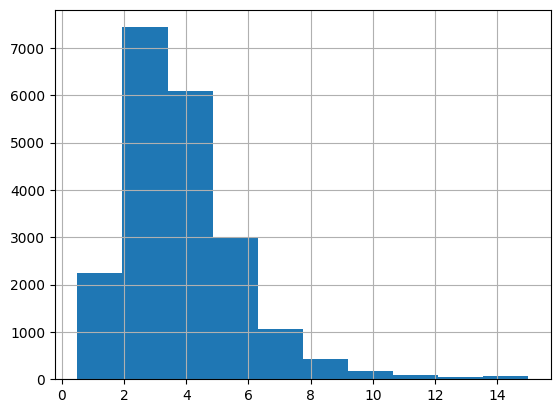

In [ ]:
housing["median_income"].hist()

<Axes: xlabel='median_income', ylabel='Count'>

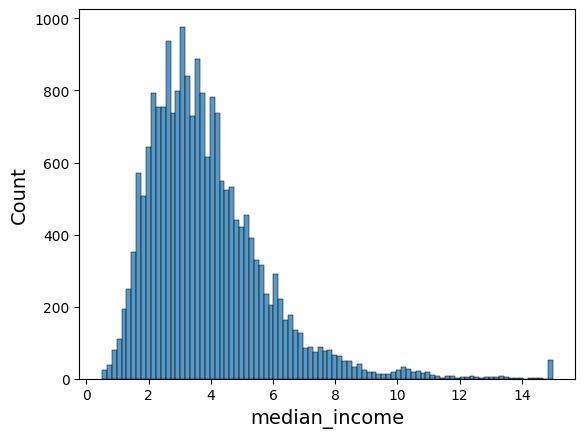

In [ ]:
sns.histplot(x='median_income', data=housing)

In [ ]:
# 전문가로부터 "중위 소득"이 중위 주택 가격을 예측하는 데에 중요한 피처라고 말했다고 해봅시다.
# 당신은 테스트 셋이 전체 데이터셋의 중위 소득의 분포를 잘 대변하길 바랄 것입니다.  
# 중위 소득의 히스토그램을 보기 위해 범주형 변수로 잠시 만들어 봅시다. pd.cut()을 이용할 수 있습니다.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

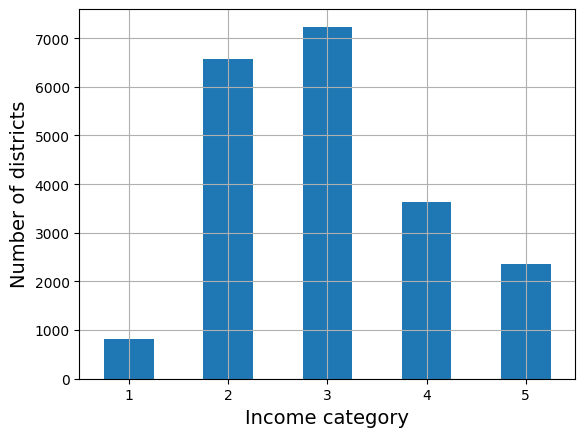

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

<Axes: xlabel='income_cat', ylabel='Count'>

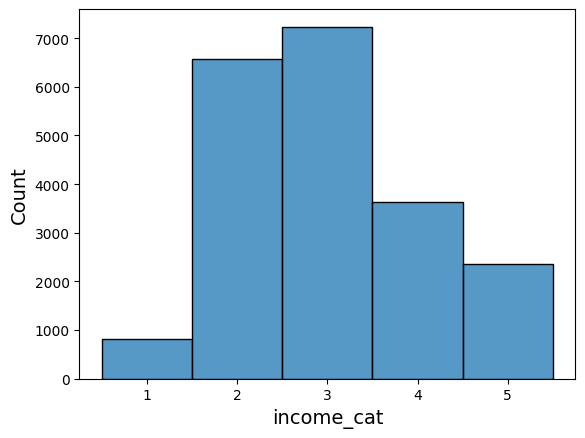

In [ ]:
sns.histplot(data=housing, x="income_cat")

In [ ]:
# 전체 분포를 봤으므로, 계층적으로(Stratified) train set과 test set을 나눌 수 있습니다.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
# 테스트 셋에서의 중위 소득 분포
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
# 전체 데이터셋에서의 중위 소득 분포. 위의 분포랑 비슷하죠?

housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
# 전체 데이터셋의 중위 소득 분포, 
# 계층적으로 나눴을 때 테스트셋의 중위 소득 분포,
# 순수히 무작위로 나눴을 때 테스트셋의 중위 소득 분포를 출력

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
(compare_props * 100).round(2)

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,3.98,4.00,4.24,644.77,36.50
2,31.88,31.88,30.74,-358.61,-1.52
3,35.06,35.05,34.52,-153.40,-1.38
4,17.63,17.64,18.41,442.43,2.75
5,11.44,11.43,12.09,563.08,-8.47


사실 하나의 계층적 분할을 얻기 위해서는 이 방법이 훨씬 간단합니다. 실전에선 이 방법을 쓰세요.

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [ ]:
# income_cat은 임의로 만든 변수였으므로 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화

In [ ]:
housing = strat_train_set.copy()

## 지리적 데이터 시각화

<Axes: xlabel='longitude', ylabel='latitude'>

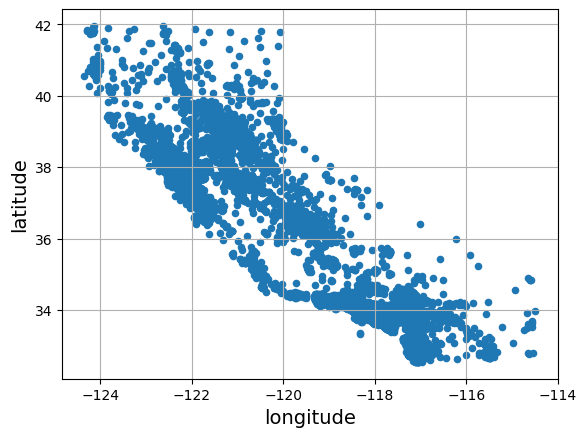

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)

<Axes: xlabel='longitude', ylabel='latitude'>

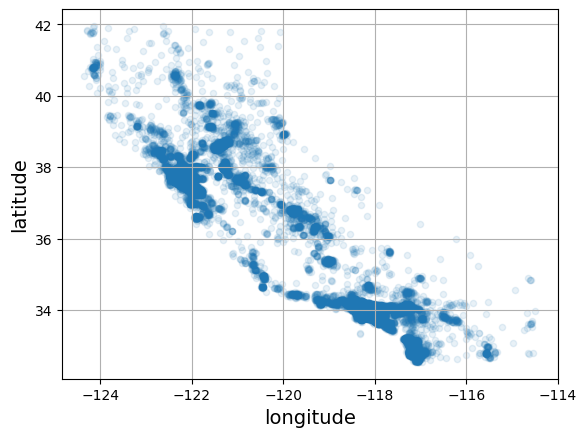

In [ ]:
# 투명도를 0.1로 두면 어느 지역에 우리 데이터셋의 주택이 몰려있는지 알 수 있습니다. 
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.1)

`sharex=False` 매개변수는 x-축의 값과 범례를 표시하지 못하는 버그를 수정합니다. 이는 임시 방편입니다(https://github.com/pandas-dev/pandas/issues/10611 참조). 수정 사항을 알려준 Wilmer Arellano에게 감사합니다.

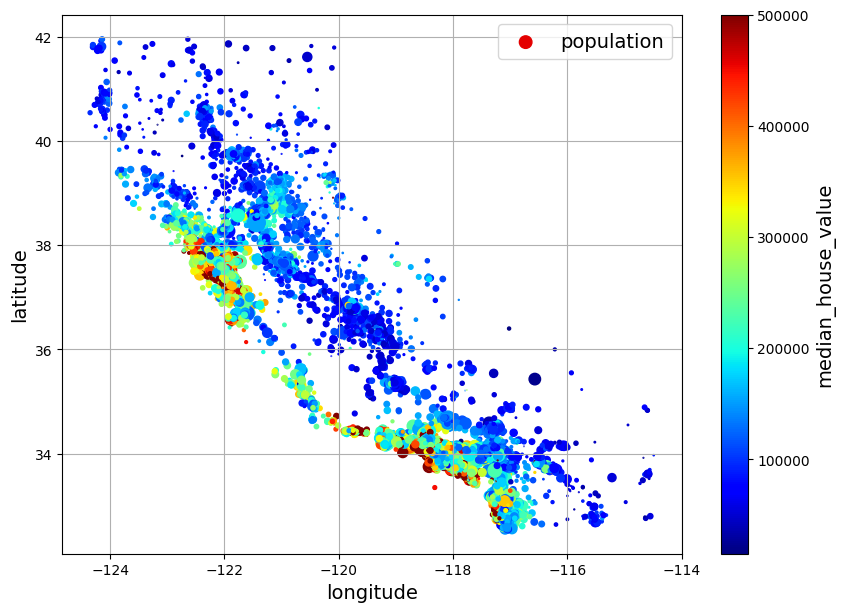

In [ ]:
# 어디에 비싼 집이 몰려있는지도 시각화해봅시다.
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.legend()

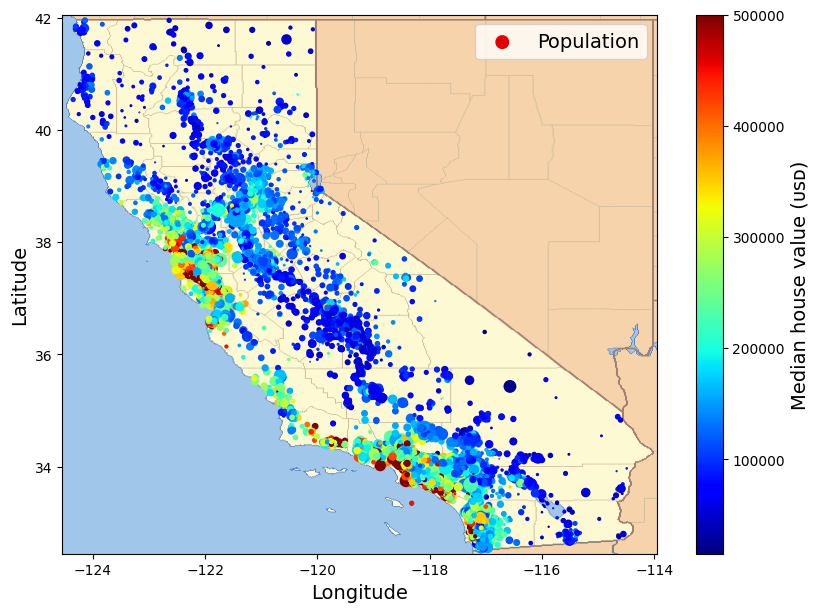

In [ ]:
# 추가 코드 – 이 셀은 이 장의 첫 번째 그림을 생성합니다

from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# 캘리포니아 이미지를 다운로드합니다
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

## 상관관계 조사

피어슨의 상관 계수(위키백과): 두 변수가 "선형적으로" 같이 움직이는 정도를 나타낸 지표.

주의: 상관계수가 0이라고 해서 두 변수 간에 관계가 없다는 뜻은 절대 아닙니다. 해석에 주의하여야 합니다.

![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)




In [ ]:
# 판다스 1.5버전부터 수치형 데이터만 포함하는지 여부를 결정하는 `numeric_only` 매개변수가 추가되었습니다.
# 이 매개변수의 기본값은 `True`입니다.
# 향후 버전에서 기본값이 `False`로 바뀐다는 경고를 피하려면 명시적으로 `numeric_only=True`로 지정하세요.
corr_matrix = housing.corr(numeric_only='True')

corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


<Axes: >

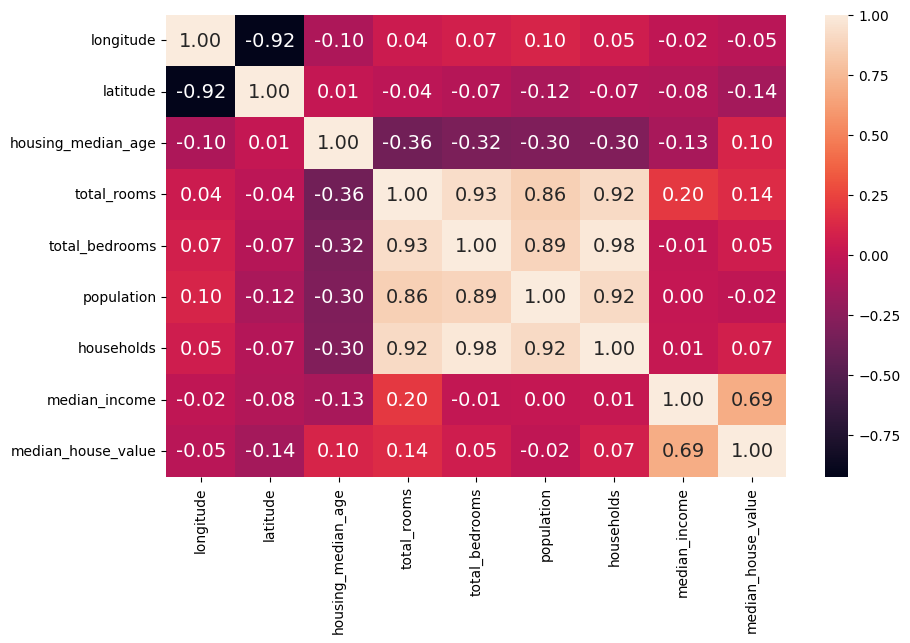

In [ ]:
# 제가 추가한 코드. 상관계수를 히트맵으로 자주 나타냅니다.
plt.figure(figsize=(10, 6))
sns.heatmap(data=corr_matrix, annot=True, fmt=".2f")

In [ ]:
# 중간 주택 가격과 "선형적인 관계"가 큰 변수를 모아봅시다.
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

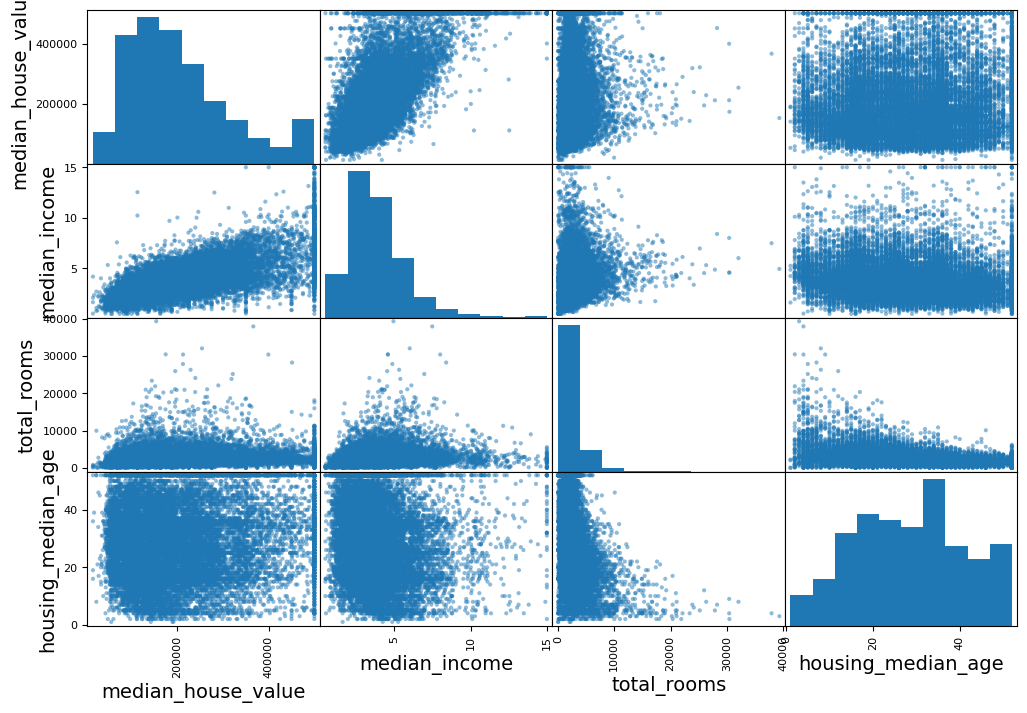

In [ ]:
# 특성 간에 상관관계를 체크하는 또 다른 방법은 이렇게 scatter_matrix를 그려서 변수 간의 관계를 시각적으로 보는 것입니다.
# 그 중에서 상관관계가 가장 높은 4개 변수를 시각화합시다.

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"] # 상관관계가 가장 높은 4개 변수
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

<Figure size 1200x800 with 0 Axes>

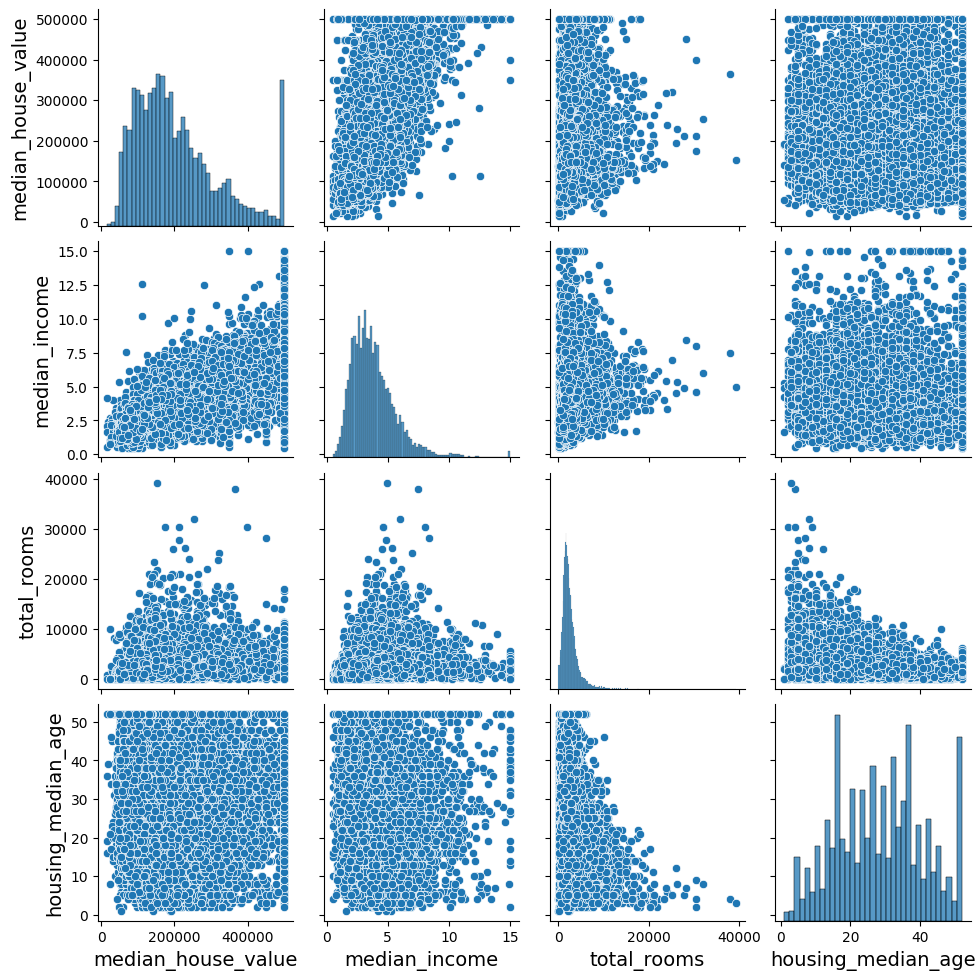

In [ ]:
# 저 개인적으론 sns.pairplot을 더 선호합니다.
plt.figure(figsize=(12, 8))
sns.pairplot(data=housing[["median_house_value", "median_income", "total_rooms", "housing_median_age"]])
plt.show()

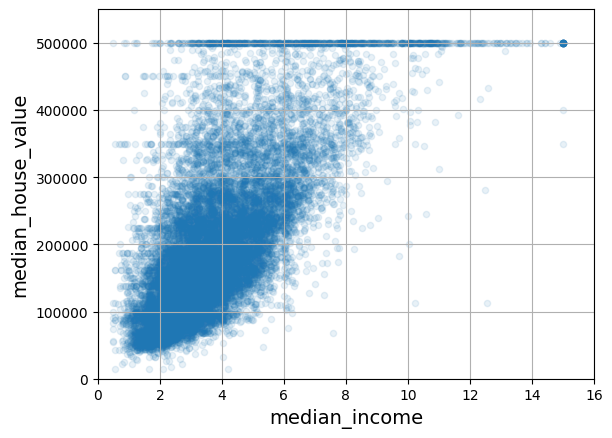

In [ ]:
# median_house_value를 예측하는 데에 가장 좋아보이는 변수는 median_income입니다. 
# 저 산점도만 따로 그려봅시다.

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.axis([0, 16, 0, 550000])
plt.show()

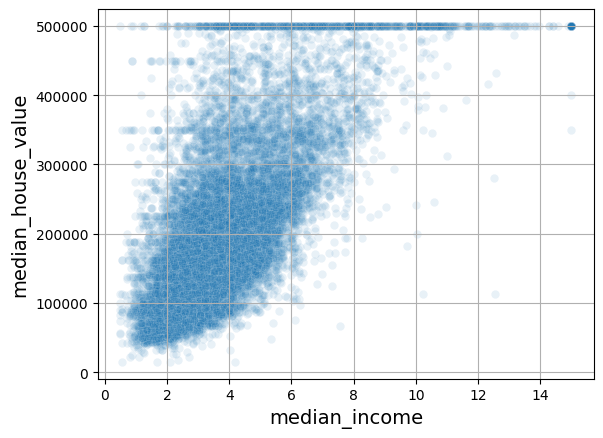

In [ ]:
# sns.scatterplot을 이용해 산점도를 그립니다.
sns.scatterplot(data=housing, x="median_income", y="median_house_value", alpha=0.1)
plt.grid()
plt.show()

In [ ]:
# 이 그래프는 몇 가지 사실을 알려줍니다. 
# 첫째, 상관관계가 매우 강합니다. 우상향하는 경향을 볼 수 있으며, 데이터포인트가 너무 멀리 퍼져있지 않습니다
# 둘째, 앞서 본 가격 제한 값이 50만 달러에서 수평선으로 너무 잘 보입니다. 45만 달러, 35만 달러, 28만 달러에도 있습니다. 
# 머신러닝 모델이 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거하는 방안을 고려할 수 있습니다. 

In [ ]:
# 이 절에서 데이터로부터 인사이트를 얻는 방법을 대충이나마 느낌을 잡았길 바랍니다.

## 특성 조합으로 실험 (피처 엔지니어링)

In [ ]:
# 머신러닝 모델의 성능을 높이기 위해 할 수 있는 또 다른 일은 피처 엔지니어링입니다.

# 예를 들어 한 구역의 가구가 몇 명인지를 모르면 특정 구역 내 주택의 방의 개수는 크게 쓸데없을 것 같습니다.
# 그래서 가구 수 대비 방 개수라는 변수를 만들겠습니다.
# 지역 내 전체 침실 개수도 별로 유용하지 않습니다. 방의 개수에 대비하여 계산하는 게 낫습니다.
# 지역 내 가구 당 인원 수도 흥미로운 특성 조합일 것 같습니다.

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [ ]:
# 새로운 변수는 타깃값과 얼마의 상관관계를 보일까요?
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

<ipython-input-36-fdec871bad1f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

In [ ]:
# 나쁘지 않네요. 
# 가구 수 대비 방의 개수(rooms_per_household)가 전체 방의 개수(total_rooms)보다 상관이 (아주 조금) 더 높습니다.
# 방 개수 대비 침실 개수 (bedrooms_per_room)의 상관관계도 약 -0.26으로 중위 소득을 제외한 다른 변수들보다 더 높습니다.
# 아쉽게도 가구 수 당 인원인 population_per_household는 타깃값과의 상관이 약 -0.02입니다.

In [ ]:
# 새로운 변수의 통계량을 출력해봅시다.

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,538.949094,1425.513929,499.990189,3.870428,206333.518653,5.441010,0.212796,2.995974
std,2.000624,2.133294,12.585738,2185.287466,423.862079,1094.795467,382.865787,1.891936,115314.047529,2.574143,0.057417,4.457373
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.888889,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,787.000000,279.000000,2.562500,119200.000000,4.443636,0.175257,2.433426
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500,179200.000000,5.235573,0.203106,2.822316
75%,-118.010000,37.720000,37.000000,3154.000000,645.000000,1726.000000,603.000000,4.750000,263925.000000,6.053843,0.239421,3.286385
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,502.461538


# 머신러닝 알고리즘을 위한 데이터 준비

참고로 아래 작업들은 나중에 자동화(파이프라인 만들기)까지 시킬 겁니다. 이유는 다음과 같습니다.

* 예를 들어 다음번에 새로운 데이터셋을 사용할 때 똑같은 데이터 변환을 손쉽게 반복할 수 있습니다.
* 향후 프로젝트에 사용할 변환 라이브러리를 점진적으로 구축하게 됩니다.
* 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전 변환시키는 데 이 함수를 사용할 수 있습니다.
* 여러가지 데이터 변환, 피처 엔지니어링을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하는 데에 편리합니다.

In [ ]:
# 이제 train set에서 타깃을 떼냅시다.

housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

## 데이터 정제

많은 머신러닝 모델이 결측치를 제대로 처리하지 못합니다. 그래서 결측치를 처리하는 함수를 몇 개 만들어봅시다.
"핸즈온 머신러닝"에서는 결측치 처리를 위해 다음의 세 가지 옵션을 소개하고 있습니다.

```
# 옵션 1. total_bedroom이 null인 행 전체를 없앤다.
housing.dropna(subset=["total_bedrooms"])    

# 옵션 2. total_bedroom 피처 자체를 삭제한다.
housing.drop("total_bedrooms", axis=1)       

# 옵션 3. 결측치를 중앙값으로 채운다.
median = housing["total_bedrooms"].median()  
housing["total_bedrooms"].fillna(median, inplace=True)
```

각 옵션이 어떤 건지 여러분께 보여드리기 위해 주택 데이터셋의 복사본을 만들어서 설명해보겠습니다. 이 때 적어도 하나의 열이 비어 있는 행만 고릅니다. 이렇게 하면 각 옵션의 정확한 동작을 눈으로 쉽게 확인할 수 있습니다.

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [ ]:
# 옵션 1. total_bedrooms 변수값이 null인 행을 모두 삭제합니다.
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [ ]:
# 옵션 2. total_bedrooms 열 자체를 아예 삭제해버립니다.
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [ ]:
# 옵션 3. 결측치를 다른 값으로 대체합니다. 여기서는 중앙값으로 채웁니다.
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

In [ ]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [ ]:
# 옵션 3의 경우 사이킷런에서도 결측치 대치 메서드를 제공합니다.

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값은 수치형 특성에서만 계산될 수 있기 때문에 범주형 변수를 삭제합니다:
(만약 범주형 변수에 결측치가 있다면, 비슷한 방법으로 최빈값으로 대치할 수 있습니다.)

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
# 각 특성의 중간값 계산
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

이제 훈련 세트의 결측치를 중앙값으로 채웁니다.

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
# 결측치가 채워졌는지 볼까요?

housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [ ]:
imputer.strategy

'median'

In [ ]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


결측치를 처리했으니 이제 이상치를 다뤄보겠습니다. sklearn의 IsolationForest를 사용하겠습니다.

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [ ]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

이상치를 삭제하고 싶다면 다음 코드를 실행하면 됩니다.

In [ ]:
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

## 텍스트와 범주형 특성 다루기

이제 범주형 입력 특성인 `ocean_proximity`을 전처리합니다:

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


머신러닝 모델은 이렇게 문자열로 입력받기보다 숫자로 입력받길 원합니다. 

문자열을 숫자로 바꾸는 작업을 사이킷런을 이용해서 해 봅시다.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

한 가지 이슈가 있습니다. 머신러닝 알고리즘은 숫자 차이가 더 가까운 것일수록 class의 성격도 더 가까울 것이라 생각합니다. 

이러한 것은 순서형 변수에는 도움이 되겠지만, 그냥 범주형 변수에는 문제가 생깁니다. 범주형 변수의 class 간에는 서열이 없기 때문입니다.

이런 경우, 원-핫-인코딩을 사용할 수 있습니다. 만약 class가 총 5개 있다면 크기가 5인 배열을 만들어, 각 class에 해당하는 인덱스에선 배열의 원소값이 1, 나머지는 0으로 만드는 겁니다. [1, 0, 0, 0, 0] 이런 식으로요. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

OneHotEncoder는 기본적으로 사이파이의 희소 행렬을 반환합니다. 만약 필요하면 toarray() 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

또는 OneHotEncoder를 만들 때 매개변수를 sparse_output=False로 지정할 수 있습니다:

In [ ]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# 특성 스케일링

데이터에 적용할 가장 중요한 변환 중 하나가 특성 스케일링입니다.

몇 가지 예외적인 경우(트리 기반 알고리즘) 말고는, 입력 값의 연속형 변수끼리 스케일이 크게 차이나면 머신러닝 알고리즘이 좋은 성능을 내지 않습니다. 

우리가 지금 다루는 데이터가 딱 그렇습니다. 방의 총 개수는 6에서 39,320이지만 중위 소득은 0에서 15 사이입니다. 

이렇게 스케일이 다르면, 머신러닝 알고리즘이 훈련 시에 착각을 합니다. 스케일이 넓은 방의 총 개수는 중요하다고 생각하고, 스케일이 작은 중위 소득은 예측에 별 도움이 안된다고 머신러닝 모델이 판단할 것입니다.

따라서 모든 입력 변수들의 스케일을 비슷하게 맞춰줘야 합니다.

데이터 스케일러 5개를 사이킷런이 제공합니다. 
* `StandardScaler`: 특성들의 평균을 0, 분산을 1인 정규분포로 만들어 줍니다. 이상치에 민감합니다. (Z = (변량 - 평균)/표준편차)
* `MinMaxScaler`: 특성의 최솟값을 0, 최댓값을 1로 만들어 줍니다. 이상치에 민감합니다.
* `MaxAbsScaler`: 특성의 최솟값을 -1, 최댓값을 1로 만들어 줍니다(절댓값의 최댓값이 1이 됨) 이상치에 민감합니다.
* `RobustScaler`: 평균과 분산 대신 중앙값과 사분위수를 사용합니다. StandardScaler, MinMaxScaler, MaxAbsScaler가 이상치에 민감하다는 점을 보완해줍니다.
* `Normalizer`: 특성(열)이 아니라 각 샘플 혹은 레코드(행)에 적용되는 것으로, 한 행의 모든 특성들 사이의 L2 norm(유클리드 거리)가 1이 되도록 스케일링합니다. 이렇게 하면 좀 더 빠르게 학습할 수 있고 과대적합 확률을 낮출 수 있다고 합니다.

그리고 타깃값은 꼭 스케일링할 필요는 없지만, 회귀 문제의 경우 타깃의 분포가 한쪽으로 너무 치우쳐있다면(꼬리가 길다면) log값을 취해주는 등 가능한 정규분포(종 모양의 곡선)에 가깝게 변환을 해주면 좋습니다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [ ]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

스케일링된 건 좋은데, 모든 열 전체가 스케일링되었습니다. 조금 있다가 특정 열만 스케일링하는 방법을 보겠습니다.

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [ ]:
housing_num_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

그리고 특성의 분포가 한쪽으로 치우쳐있다면 로그 변환 등을 통해 대칭에 가깝게 바꿔주세요.

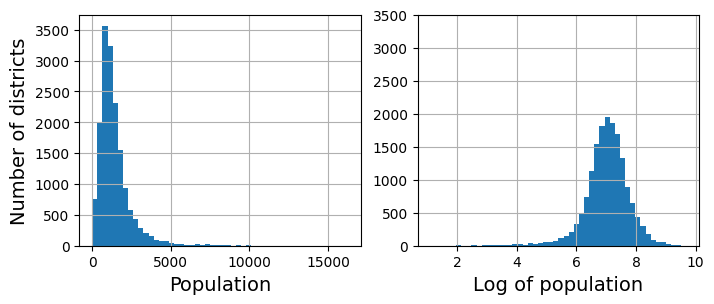

In [ ]:
# 추가 코드: 특성의 분포가 너무 왼쪽으로 치우쳐있다면 로그 변환
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
housing["population"].hist(ax=axes[0], bins=50)
housing["population"].apply(np.log).hist(ax=axes[1], bins=50)
axes[0].set_xlabel("Population")
axes[1].set_xlabel("Log of population")
axes[0].set_ylabel("Number of districts")
axes[1].set_ylim((0, 3500))
plt.show()

각 값을 백분위수로 바꾸면 어떻게 될까요?

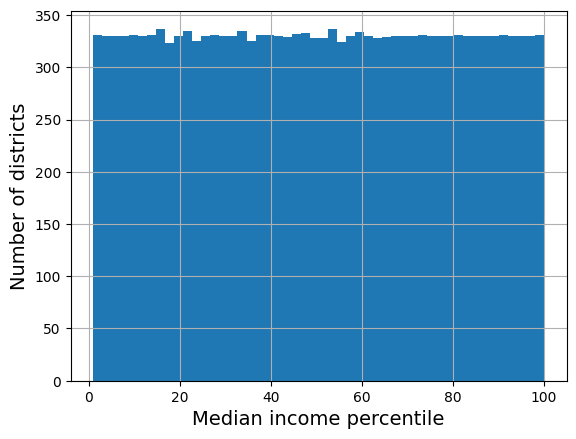

In [ ]:
# 추가 코드 – 균등 분포를 얻는다는 것을 보여줍니다
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: 1 백분위수 아래의 소득은 1로 레이블되고 99 백분위수 이상의 값은 100으로 레이블됩니다.
# 이 때문에 아래 분포의 범위가 1에서부터 100까지입니다(0에서부터 100까지가 아닙니다).

In [ ]:
# 이 부분(커널 기법)은 우리 스터디에서 다루지 않을 내용입니다.
# kernel 어쩌고 하는 부분은 자세히 들여다볼 필요 없습니다.

from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

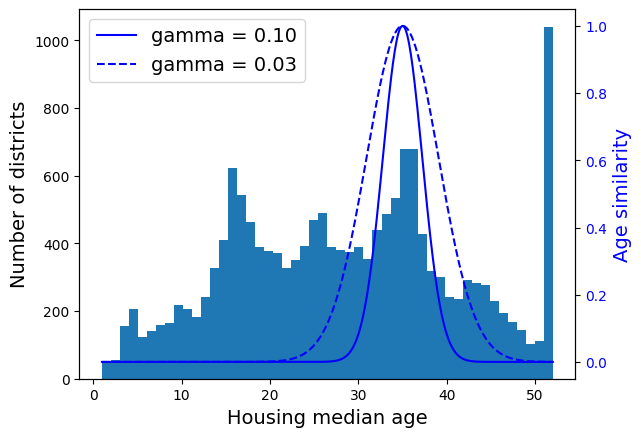

In [ ]:
# 추가 코드 – 이 셀은 그림 2–18을 생성 합니다 

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # x축을 공유 하는 쌍둥이 축을 만듭니다
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # 새로운 데이터라고 가정합니다

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [ ]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [ ]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## 사용자 정의 변환기

여기서는 변환기를 만듭니다.

그런데 제가 보기엔 우리 수준에서는 이런 거까지는 꼭 쓸 필요는 없다고 생각되므로, "아~ 이런 게 있구나" 하고 넘기면 될 것 같습니다. 

만약 나중에 우리 스터디 실습 시에 이런 작업이 필요하다고 생각이 들면 판다스의 .apply() 메서드 등을 이용하여 간편히 작업해주면 되겠습니다.

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# 인구 변수를 정규분포에 가깝게 만들어줌
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [ ]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [ ]:
# 위도와 경도를 그대로 쓰지 않고 유사도를 구해서 바꿔쓰는 건데, 그냥 이런 게 있구나 하고 생각하면 됩니다.

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [ ]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [ ]:
# 비율을 계산해주는 변환기입니다.

ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [ ]:
# 아까 봤던 StandardScaler를 직접 만드는 작업입니다.
# 우리 수준에서 굳이 이런 걸 만들 필요는 없습니다. 필요하다면 만들면 됩니다.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # *args나 **kwargs를 사용하지 않습니다!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # 사용하지 않더라도 y를 넣어 주어야 합니다
        X = check_array(X)  # X가 부동소수점 배열인지 확인합니다
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # 모든 추정기는 fit()에서 이를 저장합니다.
        return self  # 항상 self를 반환합니다!

    def transform(self, X):
        check_is_fitted(self)  # (훈련으로) 학습된 속성이 있는지 확인합니다
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [ ]:
from sklearn.cluster import KMeans

# 군집화는 쉽게 말해 비슷한 성격의 데이터끼리 묶는 겁니다.
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        # 사이킷런 1.2버전에서 최상의 결과를 찾기 위해 반복하는 횟수를 지정하는 `n_init` 매개변수 값에 `'auto'`가 추가되었습니다.
        # `n_init='auto'`로 지정하면 초기화 방법을 지정하는 `init='random'`일 때 10, `init='k-means++'`일 때 1이 됩니다.
        # 사이킷런 1.4버전에서 `n_init`의 기본값이 10에서 `'auto'`로 바뀝니다. 경고를 피하기 위해 `n_init=10`으로 지정합니다.
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # 항상 self를 반환합니다!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"클러스터 {i} 유사도" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [ ]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

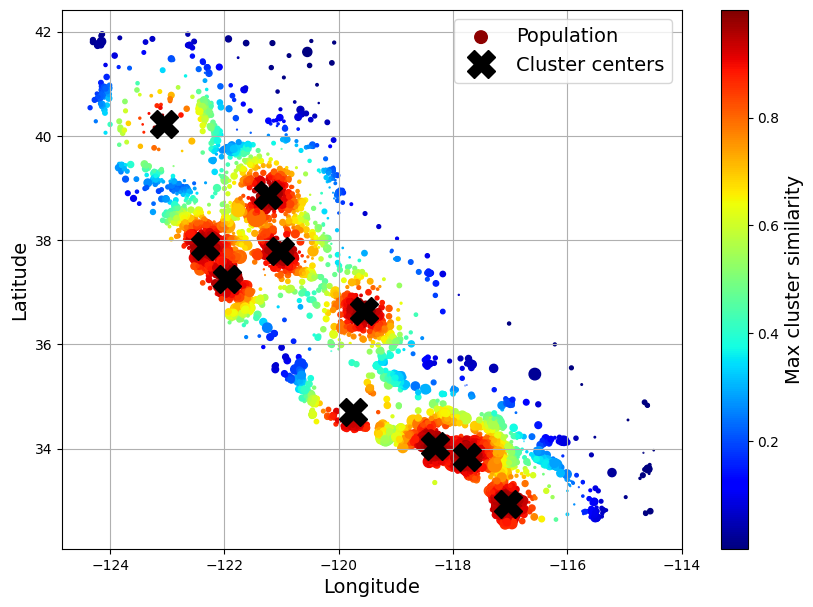

In [ ]:
# 추가 코드 – 이 셀은 그림 2–19를 생성합니다

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

## 변환 파이프라인

수치형 특성을 전처리하는 과정을 자동화하기 위해 파이프라인을 만듭니다.

사실 제가 보기에 이 부분도 초심자 수준에서 꼭 필요하진 않은 것 같습니다. 만약 실습 시에 필요하게 된다면 참고하세요.

In [ ]:
from sklearn.pipeline import Pipeline

# 여러 작업을 묶어서 한개의 파이프라인으로 만들어 줍니다.
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [ ]:
from sklearn.pipeline import make_pipeline

# 파이프라인에 이름을 빼고 생성
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
from sklearn import set_config

# 파이프라인의 동작을 설명하는 다이어그램을 생성
set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
# def monkey_patch_get_signature_names_out():
#     """Monkey patch some classes which did not handle get_feature_names_out()
#        correctly in Scikit-Learn 1.0.*."""
#     from inspect import Signature, signature, Parameter
#     import pandas as pd
#     from sklearn.impute import SimpleImputer
#     from sklearn.pipeline import make_pipeline, Pipeline
#     from sklearn.preprocessing import FunctionTransformer, StandardScaler

#     default_get_feature_names_out = StandardScaler.get_feature_names_out

#     if not hasattr(SimpleImputer, "get_feature_names_out"):
#       print("Monkey-patching SimpleImputer.get_feature_names_out()")
#       SimpleImputer.get_feature_names_out = default_get_feature_names_out

#     if not hasattr(FunctionTransformer, "get_feature_names_out"):
#         print("Monkey-patching FunctionTransformer.get_feature_names_out()")
#         orig_init = FunctionTransformer.__init__
#         orig_sig = signature(orig_init)

#         def __init__(*args, feature_names_out=None, **kwargs):
#             orig_sig.bind(*args, **kwargs)
#             orig_init(*args, **kwargs)
#             args[0].feature_names_out = feature_names_out

#         __init__.__signature__ = Signature(
#             list(signature(orig_init).parameters.values()) + [
#                 Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

#         def get_feature_names_out(self, names=None):
#             if callable(self.feature_names_out):
#                 return self.feature_names_out(self, names)
#             assert self.feature_names_out == "one-to-one"
#             return default_get_feature_names_out(self, names)

#         FunctionTransformer.__init__ = __init__
#         FunctionTransformer.get_feature_names_out = get_feature_names_out

# monkey_patch_get_signature_names_out()

In [ ]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [ ]:
df_housing_num_prepared.head(2)  # 추가 코드

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [ ]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [ ]:
num_pipeline[1]

StandardScaler()

In [ ]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [ ]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [ ]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
# 아까 범주형 변수와 수치형 변수를 따로따로 나눠서 처리했죠.
# 이걸 한꺼번에 처리할 수 있다면 편할 것입니다.
# 그리고 피처 스케일링을 하니 한 가지 열이 아니라 모든 열에 다 적용되었구요.

# ColumnTransformer는 각 열에다가 적절한 처리를 해주기 위한 사이킷런 클래스입니다.
# 사이킷런 0.20 버전부터만 지원합니다.

from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

# 공식 문서에 따르면 make_column_selector는 데이터 타입, 변수명(정규표현식)을 통해 변수를 선택하는 방법입니다.
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
# 추가 코드 – 필요하다면 데이터프레임으로 만들 수 있습니다
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [ ]:
# 이제 데이터의 각 열에 필요한 전처리를 해주겠습니다.

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # get_feature_names_out에 사용

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

# 로그 변환을 해주는 파이프라인 
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
# 군집 유사도를 구해주는 변환기
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
# 결측치를 대체하고 스케일링을 해주는 파이프라인
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
# ColumnTransformer를 통해 각 열에 필요한 작업을 해주는 도구입니다.
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # 남은 특성: housing_median_age

In [ ]:
# 아까 만든 preprocessing에 우리 데이터셋에 직접 적용해봅시다.
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [ ]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

# 모델 선택과 훈련

마지막으로 모델링만 남았습니다. 

필요한 전처리(결측치 처리, 이상치 처리, 피처 엔지니어링, 범주형/순서형 변수 인코딩, 연속형 변수 스케일링 등)와 EDA(지리 정보 시각화, 피처와 타겟의 상관계수 측정, 타겟의 분포 시각화, 피처의 분포 시각화, 피처끼리의 상관관계를 히트맵으로 시각화 등)를 하였으므로, 머신러닝 모델을 선택할 차례가 되었습니다.

## 훈련 세트에서 훈련하고 평가하기

In [ ]:
# 선형 회귀를 적용해봅시다. 
# 코드는 이게 끝입니다. 쉽죠? 선형회귀가 뭔지 몰라도 선형회귀 모델을 구축할 수 있습니다.
# 요즘 머신러닝 패키지들이 고수준으로 추상화되어 있어서, 코딩보다는 이론을 잘 이해하는 것이 중요하겠습니다.

from sklearn.linear_model import LinearRegression

# lin_reg = LinearRegression()
# lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# 이 작업까지 파이프라인으로 묶으면 이렇게 됩니다. 
# 우리는 위의 셀이 아니라 아래 셀을 실행하겠습니다.
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f8...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f83d1a6fc10>)])),
                ('linearregression', LinearRegression())])

실제 값과 비교합니다:

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5] # 모델의 예측값

array([243713.20602735, 372357.32638638, 128778.47225482,  94384.39139877,
       328265.32697444])

In [ ]:
housing_labels.iloc[:5].values # 실제값

array([458300., 483800., 101700.,  96100., 361800.])

이제 모델을 평가해보겠습니다. 회귀 평가 지표는 다음과 같습니다.

MSE: (실제값 - 모델예측)^2의 평균 = 오차 제곱의 평균 

MAE: |실제값 - 모델예측|의 평균 = |오차|의 평균

RMSE: MSE에 양의 제곱근을 취한 값

그 외 MSLE, RMSLE, R^2, 기타 등등... 이 부분은 너무 간단한 부분이므로 직접 찾아보시면 되겠습니다.

In [ ]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68687.89176590038

**노트**: 사이킷런 0.22 버전부터는 `squared=False` 매개변수로 `mean_squared_error()` 함수를 호출하면 RMSE를 바로 얻을 수 있습니다.

In [ ]:
mean_squared_error(housing_labels, housing_predictions, squared=False)

68687.89176590038

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

50923.43416357462

타깃값의 분포가 120000달러에서 265000달러 사이인데, RMSE가 68688달러나 된다니 너무 큽니다. MAE는 50923달러로 그나마 낮지만 어쨌든 오차가 큽니다. 

이는 모델이 과소적합된 사례입니다. 우리는 규제를 사용하지 않았으므로, 선형 회귀 말고 더 복잡한 모델을 쓰는 걸 고려할 수 있습니다. 따라서 결정 트리라는 모델을 사용해보겠습니다.(지금은 뭔지 몰라도 됩니다.)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# tree_reg = DecisionTreeRegressor(random_state=42)
# tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# 파이프라인으로 만들어줍니다. 우리는 위의 셀 말고 이 셀을 실행하겠습니다.
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f8...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f83d1a6fc10>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

이번엔 오차가 0.0입니다. 와... 완벽하네요.

머신러닝을 공부한 여러분은 속으면 안됩니다. 이는 과대적합일 가능성이 큽니다. 이런 경우 테스트 데이터를 잘 예측하는지도 무조건 체크해야 합니다.

## 교차 검증을 사용한 평가

사이킷런에서는 교차 검증(Cross Validation)을 지원합니다.
다음 코드는 K-Fold Validation(K-폴드 교차검증)을 실행한 것입니다.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmses = np.sqrt(-scores) 
tree_rmses

# 사이킷런의 교차검증 기능은 scoring 매개변수가 비용함수가 아닌 효용함수이기를 기대합니다. 
# 그래서 평균 제곱 오차에 부호를 반대로 한 값을 계산하는 neg_mean_squared_error를 사용합니다.
# 그래서 코드 마지막 줄에 scores에 -를 붙여주어 RMSE를 계산해준 것입니다.

array([66506.70121103, 67097.20497743, 66144.65155743, 65069.22056897,
       64727.51994473, 70094.77824639, 67685.73110573, 68411.33556978,
       69293.5932016 , 63649.53649274])

In [ ]:
# 현재는 scoring 파라미터를 neg_mean_squared_error로 지정하면 위 셀과 똑같은 계산을 해줍니다.

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([66506.70121103, 67097.20497743, 66144.65155743, 65069.22056897,
       64727.51994473, 70094.77824639, 67685.73110573, 68411.33556978,
       69293.5932016 , 63649.53649274])

In [ ]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [ ]:
# 결정 트리의 성능을 Cross Validation를 통해 RMSE를 구해본 결과 66868가 나왔습니다.
# 아까 Train set에 대해서는 0.0의 RMSE가 나왔었죠?
# 따라서 아까 0.0의 에러는 훈련 세트에 과적합되었음을 알 수 있습니다.
# 선형 회귀에 대해서도 똑같이 해보겠습니다.

In [ ]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
# display_scores(lin_rmse_scores)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

다음엔 랜덤 포레스트라는 모델을 사용해보겠습니다. 랜덤 포레스트는 쉽게 말해 여러 피처들 중 일부만 골라 데이터셋을 여러 개 만들고, 결정 트리도 여러 개 만들어서 다양한 트리를 학습시켜 결과를 평균내는 방법입니다. (나중에 발표자가 설명할 것이므로 무슨 뜻인지 몰라도 좋습니다.) 코드는 아까와 비슷합니다.

**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f8...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f83d1a6fc10>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

훈련 세트로 측정한 RMSE(훈련 에러)와 교차 검증으로 측정한 RMSE(검증 에러)를 비교해 보죠:

In [ ]:
housing_predictions = forest_reg.predict(housing)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

17474.619286483998

In [ ]:
# 이 셀은 실행하는 데 몇 분 이상 걸릴 수 있습니다.

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

훈련 에러가 검증 에러 보다 훨씬 낮기 때문에 모델이 훈련 세트에 과대적합되었다는 의미입니다. 가능한 또 다른 이유는 훈련 데이터와 검증 데이터의 불일치입니다. 여기서는 한 데이터 셋을 섞은 다음 두 부분으로 나누었기 때문에 이 경우에 해당하지 않습니다.

# 하이퍼파라미터 튜닝

사이킷런에서는 그리드 서치, 랜덤 서치 등을 제공합니다. 자세한 설명은 여기를 참고하세요. 

https://dacon.io/competitions/open/235698/talkboard/403915 

https://datarian.io/blog/grid-search-random-search

## 그리드 탐색

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
#     {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
#     # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
#   ]

# forest_reg = RandomForestRegressor(random_state=42)
# # 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
# grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
#                            scoring='neg_mean_squared_error',
#                            return_train_score=True)
# grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f83d1a6fc10>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

`full_pipeline.get_params().keys()`를 사용해 전체 하이퍼파라미터 리스트를 얻을 수 있습니다:

In [ ]:
# 추가 코드 – get_params().keys() 출력의 일부를 보여 줍니다
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose'

최상의 파라미터 조합은 다음과 같습니다:

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [ ]:
# grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f83d4a...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f83d1b18e80>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# 추가 코드 – 데이터프레임을 깔끔하게 출력하기 위한 코드입니다
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


## 랜덤 탐색

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# param_distribs = {
#         'n_estimators': randint(low=1, high=200),
#         'max_features': randint(low=1, high=8),
#     }

# forest_reg = RandomForestRegressor(random_state=42)
# rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
#                                 n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
# rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7071466e48>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7071e76780>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
# cvres = rnd_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

30개(`n_iter` × `cv`)의 랜덤한 하이퍼파라미터 조합을 시도합니다:

**경고:**  다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f83d1b1f730>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f83d1b1f130>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# 추가 코드 – 랜덤 탐색 결과를 출력합니다
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41287,42071,42627,41995
8,32,7,41690,42513,43224,42475
0,41,16,42223,42959,43321,42834
5,42,4,41818,43094,43817,42910
2,23,8,42264,42996,43830,43030


## 최상의 모델과 오차 분석

In [ ]:
final_model = rnd_search.best_estimator_  # 전처리 포함됨
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [ ]:
# 변수 중요도를 출력합니다.

sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__클러스터 0 유사도'),
 (0.02879263999929514, 'geo__클러스터 28 유사도'),
 (0.023530192521380392, 'geo__클러스터 24 유사도'),
 (0.020544786346378206, 'geo__클러스터 27 유사도'),
 (0.019873052631077512, 'geo__클러스터 43 유사도'),
 (0.018597511022930273, 'geo__클러스터 34 유사도'),
 (0.017409085415656868, 'geo__클러스터 37 유사도'),
 (0.015546519677632162, 'geo__클러스터 20 유사도'),
 (0.014230331127504292, 'geo__클러스터 17 유사도'),
 (0.0141032216204026, 'geo__클러스터 39 유사도'),
 (0.014065768027447325, 'geo__클러스터 9 유사도'),
 (0.01354220782825315, 'geo__클러스터 4 유사도'),
 (0.01348963625822907, 'geo__클러스터 3 유사도'),
 (0.01338319626383868, 'geo__클러스터 38 유사도'),
 (0.012240533790212824, 'geo__클러스터 31 유사도'),
 (0.012089046542256785, 'geo__클러스터 7 유사도'),
 (0.01152326329703204, 'geo__클러스터 23 유사도'),
 (0.

## 테스트 세트로 시스템 평가하기

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.40026462184


테스트 RMSE에 대한 95% 신뢰 구간을 계산합니다:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

다음과 같이 수동으로 계산할 수도 있습니다:

In [ ]:
# 추가 코드 – RMSE에 대한 신뢰 구간 계산 방법
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39275.40861216077, 43467.2768058342)

또한 t-점수 대신 z-점수를 사용할 수 있습니다. 테스트 세트가 너무 작지 않기 때문에 큰 차이가 없습니다:

In [ ]:
# 추가 코드 – z-점수를 사용해 신뢰 구간 계산하기
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39276.05610140007, 43466.691749969636)

## `joblib`를 사용한 모델 저장

최종 모델을 저장합니다:

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

이제 모델을 제품 환경에 배포할 수 있습니다. 예를 들어, 제품 환경에서 실행하기 위한 스크립트는 다음과 같을 것입니다:

In [ ]:
import joblib

# 추가 코드 – 책에는 간결함을 위해 제외함
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # 새로운 구역이라 가정
predictions = final_model_reloaded.predict(new_data)

In [ ]:
predictions

array([442737.15, 457566.06, 105965.  ,  98462.  , 332992.01])

`pickle`을 사용할 수도 있지만 `joblib`이 더 효율적입니다.

## `RandomizedSearchCV`를 위한 Scipy 분포 함수

하이퍼파라미터를 위한 샘플링 분포 선택 방법

* `scipy.stats.randint(a, b+1)`: a~b 사이의 _이산적인_ 값을 가진 하이퍼파라미터. 이 범위의 모든 값은 동일한 확률 가집니다.
* `scipy.stats.uniform(a, b)`: 매우 비슷하지만 _연속적인_ 파라미터에 사용합니다.
* `scipy.stats.geom(1 / scale)`: 이산적인 값의 경우 주어진 스케일 안에서 샘플링하고 싶을 때 사용합니다. 예를 들어 scale=1000인 경우 대부분의 샘플은 이 범주 안에 있지만 모든 샘플 중 10% 정도는 100보다 작고, 10% 정도는 2300보다 큽니다.
* `scipy.stats.expon(scale)`: `geom`의 연속적인 버전입니다. `scale`을 가장 많이 등장할 값으로 지정합니다.
* `scipy.stats.loguniform(a, b)`: 하이퍼파라미터 값의 스케일을 어떻게 지정할지 모를 때 사용합니다. a=0.01, b=100으로 지정하면 0.01과 0.1 사이의 샘플링과 10과 100 사이의 샘플링 비율이 동일합니다.

다음은 `randint()`, `uniform()`, `geom()`, `expon()`에 대한 확률 질량 함수(이산형 변수)와 확률 밀도 함수(연속형 변수)의 그래프입니다:

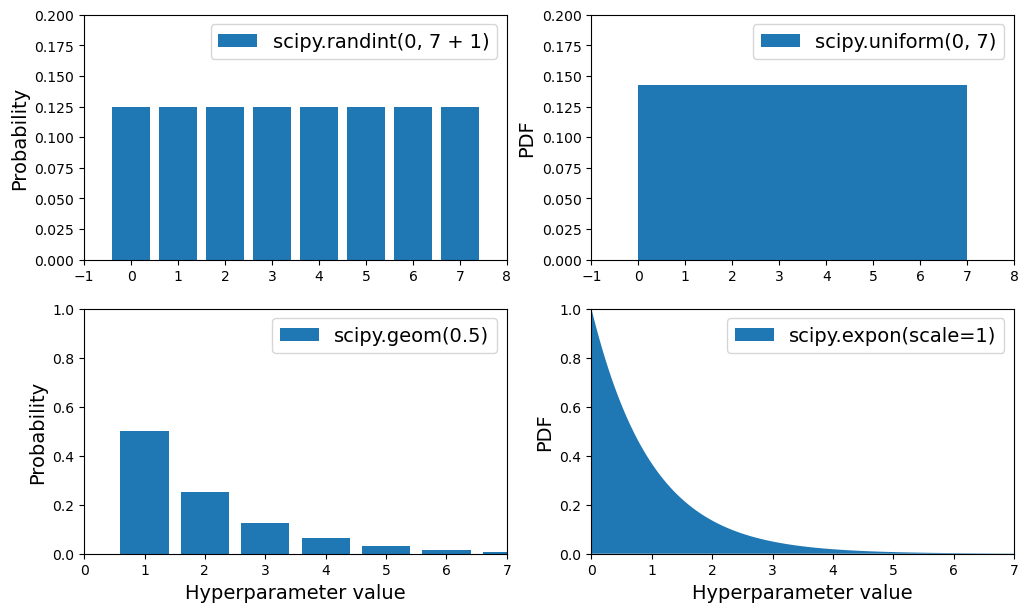

In [ ]:
# 추가 코드 – 랜덤 서치에서 사용할 수 있는 몇가지 분포에 대한 그래프

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

다음은 `expon()`와 `loguniform()`의 확률 밀도 함수(왼쪽 열), log(X)의 확률 밀도 함수(오른쪽 열)입니다. 오른쪽 열은 하이퍼파라미터 스케일의 분포를 보여줍니다. `expon()`는 대체적으로 원하는 스케일을 따라 하이퍼파라미터를 선택하고 작은 스케일 쪽으로는 긴 꼬리를 형성합니다. 하지만 `loguniform()`는 스케일에 영향을 받지 않고 모두 동일한 확률을 가집니다:

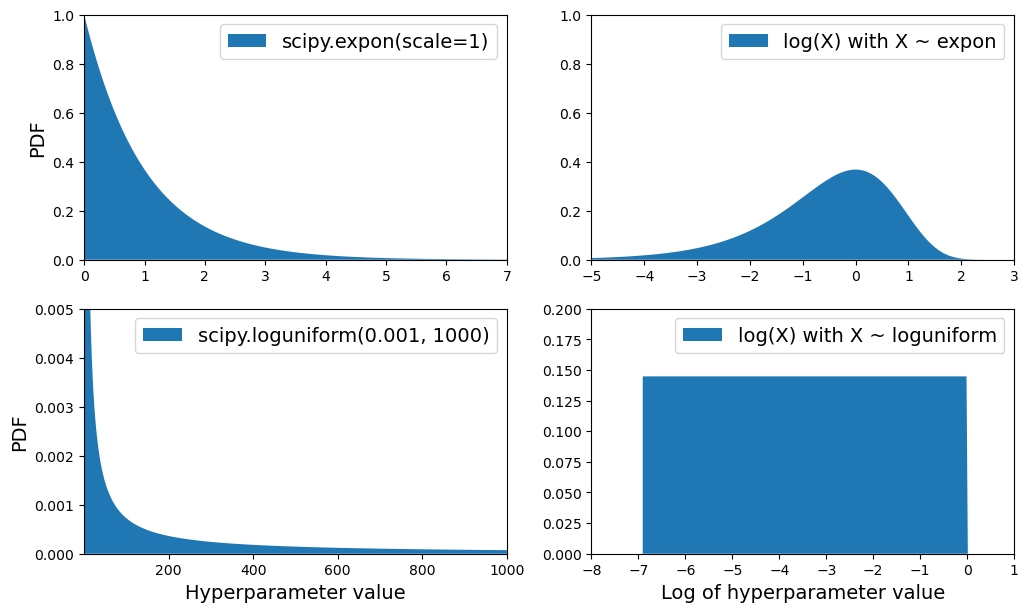

In [ ]:
# 추가 코드 – expon와 loguniform의 차이를 보여줍니다

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()